---

Load up a tonne of libraries

In [1]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh
from hangouts_loader import load_hangouts


In [2]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.sans-serif"] = ["Segoe UI Emoji"]


In [3]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)


Set your name here. This is so that you can take yourself out of some of the graphs. Because these are conversations, naievely, they go A B A B and so on, so you'll be roughly 50% of the messages, which makes other trends hard to see.

In [4]:
MY_NAME = "Ben Doherty"


In [5]:
all_convo_df = pd.read_pickle(pickle_path)
print(f"done: all_convo_df has {all_convo_df.shape[0]} rows")
all_convo_df.head()


done: all_convo_df has 1011154 rows


,sender_name,timestamp_ms,content,type,is_unsent,users,source_convo,datetime,message_length,platform,...,ip,gifs,files,audio_files,missed,event_id,input_names,initials,gender,clean_content
0,Ben Doherty,1.521518e+12,This probably isn't the best name for this,Generic,False,NaN,1161remedialsessions_b_fdlwp_va,2018-03-20 14:47:48.721,42,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me,probably isn't best name
1,Aiden Ray,1.521504e+12,Aiden waved hello to the group.,Share,False,NaN,1161remedialsessions_b_fdlwp_va,2018-03-20 10:53:53.929,31,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Aiden Ray,AR,m,aiden waved hello group
2,Ben Doherty,1.521503e+12,You waved hello to the group.,Share,False,NaN,1161remedialsessions_b_fdlwp_va,2018-03-20 10:44:18.115,29,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me,waved hello group
3,Ishaan Varshney,1.521503e+12,Ishaan Varshney left the group.,Unsubscribe,False,[{'name': 'Ishaan Varshney'}],1161remedialsessions_b_fdlwp_va,2018-03-20 10:36:13.753,31,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Ishaan Varshney,IV,m,ishaan varshney left group
4,Ishaan Varshney,1.521503e+12,Ishaan named the group 1161 Remedial Sessions.,Generic,False,NaN,1161remedialsessions_b_fdlwp_va,2018-03-20 10:35:34.327,46,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Ishaan Varshney,IV,m,ishaan named group 1161 remedial sessions


In [6]:
print(
    f"Overall, there are {len(all_convo_df)}, messages in this dataset. "
    f"These come from about {len(all_convo_df.sender_name.unique())} people, "
    f"covering a period of {str(all_convo_df.datetime.max()-all_convo_df.datetime.min()).split(' days')[0]} days "
    f"between {all_convo_df.datetime.min():%B, %Y} and {all_convo_df.datetime.max():%B, %Y}. "
    f"Over {len(all_convo_df.platform.unique())} platforms:"
)
all_convo_df.platform.value_counts()


Overall, there are 1011154, messages in this dataset. These come from about 773 people, covering a period of 5473 days between January, 2007 and January, 2022. Over 3 platforms:


Facebook     764999
Hangouts     146211
Instagram     99944
Name: platform, dtype: int64

In [7]:
all_convo_df.sender_name.value_counts()[:20]

Ben Doherty             491111
Meike Wijers             65996
Irina Belova             50626
Ivana Kuzmanovska        44566
Lucy Rimmer              38716
Jenn Martin              33271
Bree-Danielle Wyatt      22913
unknown                  15977
Karin Ke                 12737
Maddie Johanson          12651
Charles Ogilvie          12378
Natalie Barnes           11501
David Wilcox              9482
Annisa Rivera Rizal       9057
Katherine Withnell        8580
Byron Sullivan            7982
Alessandra Moschella      7623
Erika Bloomingdale        7574
Elizabeth Deacon          7468
Jülz Milthorpe            7193
Name: sender_name, dtype: int64

# Finding streaks

The goal here is to see how long communication is maintained over different sized periods.

Using [this](https://joshdevlin.com/blog/calculate-streaks-in-pandas/) as a guide, lets start by looking at streaks in just one person's comms.

In [8]:
person_of_intrerest = "Meike Wijers"
period = "1d"

In [9]:
mw_df = all_convo_df[all_convo_df.sender_name == person_of_intrerest]
mw_df.head()

,sender_name,timestamp_ms,content,type,is_unsent,users,source_convo,datetime,message_length,platform,...,ip,gifs,files,audio_files,missed,event_id,input_names,initials,gender,clean_content
355,Meike Wijers,1.631248e+12,I think yes I want!,Generic,False,NaN,adamandmeike_0a3rahrnoa,2021-09-10 14:19:35.259,19,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Meike Wijers,MW,f,think yes want
356,Meike Wijers,1.631248e+12,Oeh is it bottle brush?,Generic,False,NaN,adamandmeike_0a3rahrnoa,2021-09-10 14:19:17.658,23,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Meike Wijers,MW,f,oeh bottle brush
359,Meike Wijers,1.629189e+12,"Of course, wattle! How could I forget",Generic,False,NaN,adamandmeike_0a3rahrnoa,2021-08-17 18:29:22.204,37,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Meike Wijers,MW,f,course wattle could forget
361,Meike Wijers,1.629188e+12,Also what is this??,Generic,False,NaN,adamandmeike_0a3rahrnoa,2021-08-17 18:07:41.345,19,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Meike Wijers,MW,f,also
362,Meike Wijers,1.629188e+12,NaN,Generic,False,NaN,adamandmeike_0a3rahrnoa,2021-08-17 18:07:37.162,3,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Meike Wijers,MW,f,NaN


Text(0.5, 1.0, 'Number of messages per day recieved from Meike Wijers')

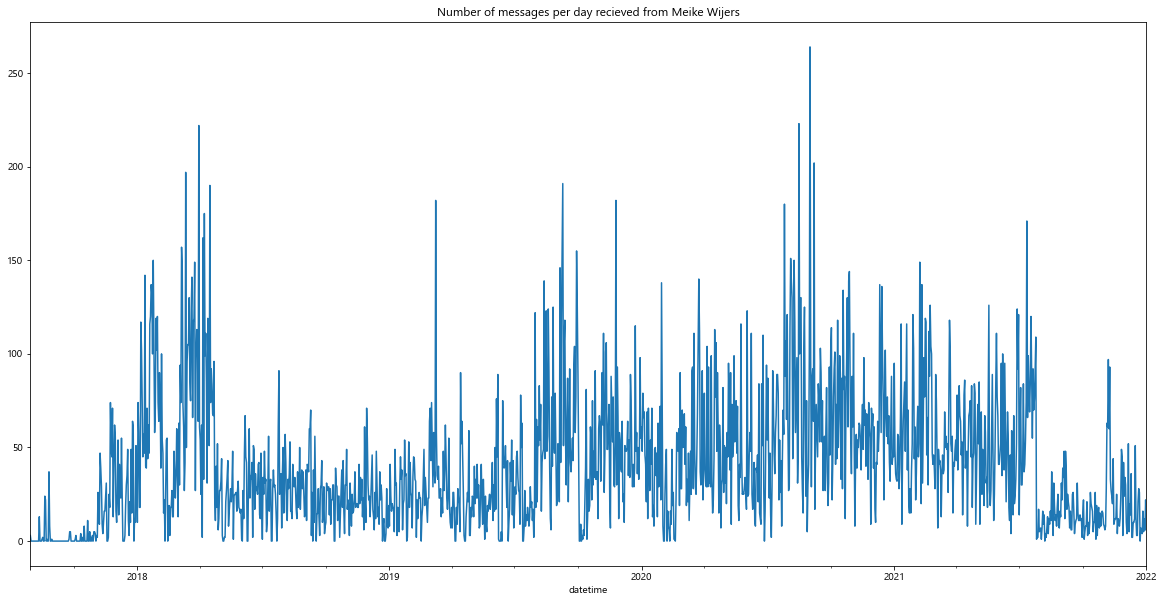

In [10]:
mpd = mw_df.set_index("datetime").groupby(pd.Grouper(freq=period)).count().sender_name
mpd.plot()
plt.title(f"Number of messages per day recieved from {person_of_intrerest}")


In [11]:
m_df = mpd.to_frame(name="message_count")
m_df["message_flag"] = m_df.message_count.apply(lambda x: x > 0)
m_df["start_of_streak"] = m_df.message_flag.ne(m_df.message_flag.shift())
m_df["streak_id"] = m_df.start_of_streak.cumsum()
m_df["streak_counter"] = m_df.groupby("streak_id").cumcount() + 1
m_df.streak_counter = m_df.apply(
    lambda row: row.streak_counter if row.message_flag else 0,
    axis=1
)
m_df.head()


,message_count,message_flag,start_of_streak,streak_id,streak_counter
datetime,,,,,
2017-07-30,3,True,True,1,1
2017-07-31,0,False,True,2,0
2017-08-01,0,False,False,2,0
2017-08-02,0,False,False,2,0
2017-08-03,0,False,False,2,0


Text(0, 0.5, 'number of 1ds of continuous communication')

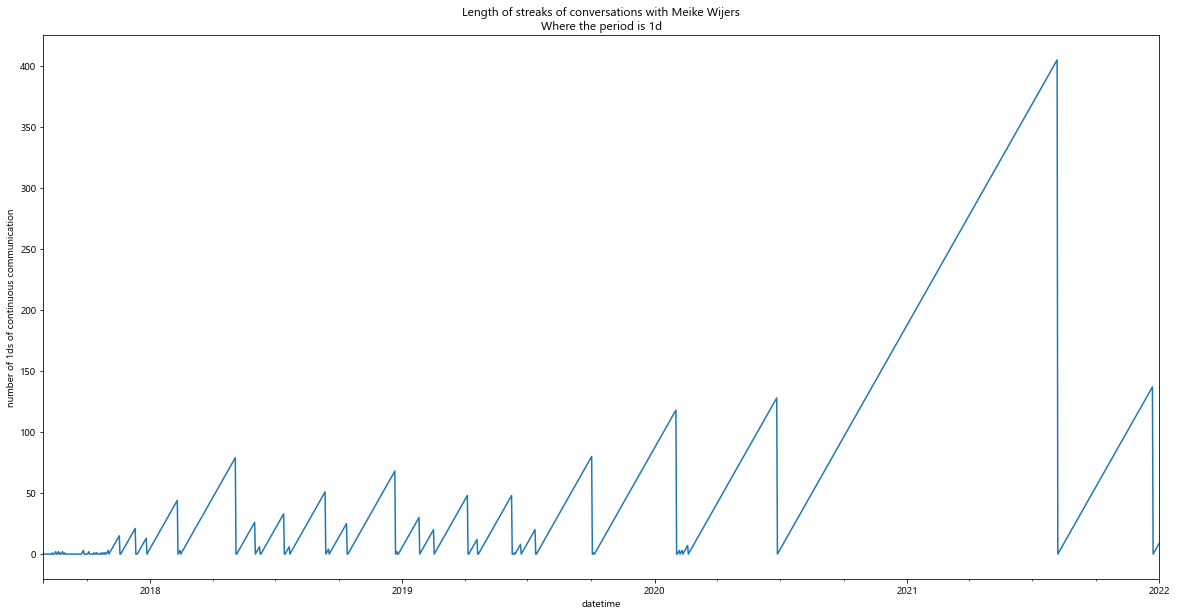

In [12]:
m_df["streak_counter"].plot()
plt.title(
    f"Length of streaks of conversations with {person_of_intrerest}\n"
    f"Where the period is {period}"
)
plt.ylabel(f"number of {period}s of continuous communication")

In [18]:
def make_streak_df(convo_df, period="1d"):
    poi_list = []
    for person_of_intrerest in convo_df.sender_name.unique():
        mw_df = convo_df[convo_df.sender_name == person_of_intrerest]
        mpd = (
            mw_df.set_index("datetime")
            .groupby(pd.Grouper(freq=period))
            .count()
            .sender_name
        )
        m_df = mpd.to_frame(name="message_count")
        m_df["message_flag"] = m_df.message_count.apply(lambda x: x > 0)
        m_df["start_of_streak"] = m_df.message_flag.ne(m_df.message_flag.shift())
        m_df["streak_id"] = m_df.start_of_streak.cumsum()
        m_df["streak_counter"] = m_df.groupby("streak_id").cumcount() + 1
        m_df.streak_counter = m_df.apply(
            lambda row: row.streak_counter
            if row.message_flag
            else (-1 * row.streak_counter),
            axis=1,
        )
        s = m_df.streak_counter
        s.index = s.index.normalize()
        poi_list.append(s.to_frame(name=person_of_intrerest))

    everyone_df = pd.concat(poi_list, axis="index")
    # This last step is really nasty. I can't work out why it's not concatenating 
    # the DFs nicely and merging the common index values.
    everyone_df = everyone_df.groupby(pd.Grouper(freq=period)).sum() 
    return everyone_df


everyone_df = make_streak_df(all_convo_df, "1d")


<Figure size 1440x720 with 0 Axes>

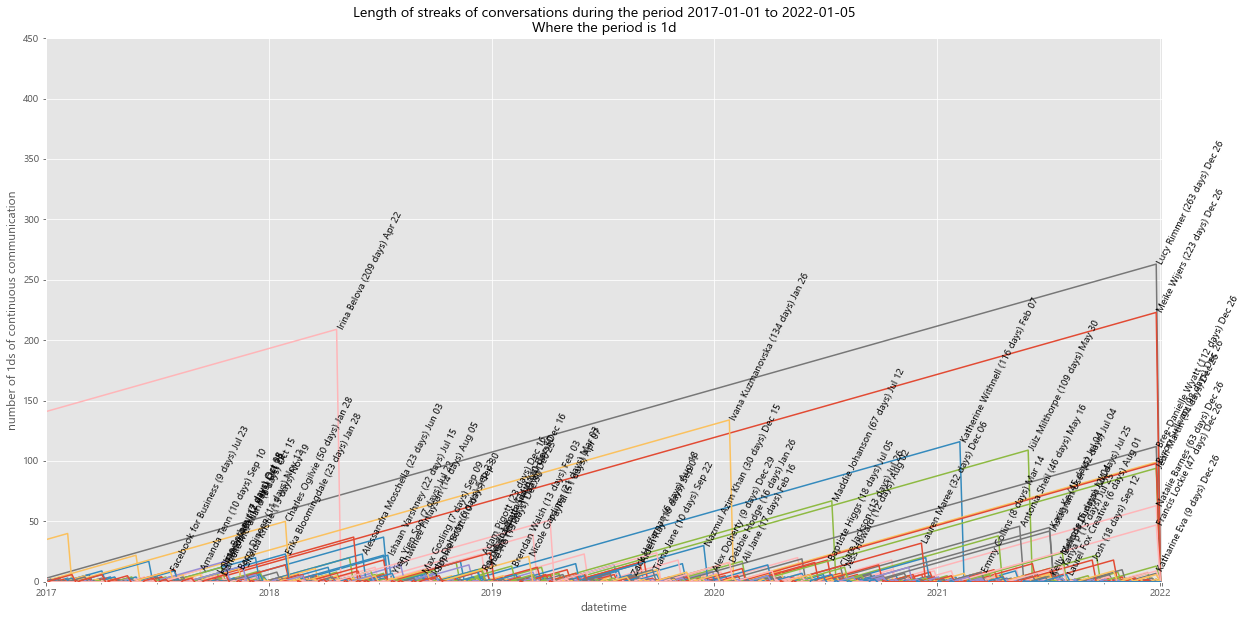

In [22]:
def plot_streak_graph(
    df,
    period="1d",
    period_name="days",
    time_span=["2013-01-01", "2022-01-05"],
    ylim=[0, 500],
):
    plt.figure()
    plt.style.use("ggplot")

    trim = df.drop(MY_NAME, axis="columns")
    trim.fillna(0).plot(kind="line", style="-", legend=None)
    # trim.interpolate().plot(kind="line", style="-", legend=None)

    if time_span:
        plt.xlim(time_span)
    else:
        time_span = [df.index[0], df.index[-1]]
    if ylim:
        plt.ylim(ylim)
    else:
        for col in trim:
            peak = trim[col].min()
            peak_idx = trim[col].idxmin()
            plt.annotate(
                f"{col} ({peak} {period_name})",
                (peak_idx, peak),
                rotation=90,
                ha="left",
            )
    # Rotate text (https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/text_rotation_relative_to_line.html)
    raw_ang = np.array((45,))
    l2 = np.array((1, 1))
    trans_ang = plt.gca().transData.transform_angles(raw_ang, l2.reshape((1, 2)))[0]

    for col in trim:
        peak = trim[col].max()
        if peak > 5:
            peak_idx = trim[col].idxmax()
            plt.annotate(
                f"{col} ({int(peak)} {period_name}) {peak_idx.strftime('%b %d')}",
                (peak_idx, peak),
                rotation=trans_ang,
                ha="left",
            )

    # plt.legend(ncol=5)
    plt.title(
        f"Length of streaks of conversations during the period {time_span[0]} to {time_span[1]}\n"
        f"Where the period is {period}"
    )
    plt.ylabel(f"number of {period}s of continuous communication")
    plt.show()


plot_streak_graph(everyone_df, period="1d", time_span=["2017-01-01", "2022-01-05"], period_name="days", ylim=[0, 450])


<Figure size 1440x720 with 0 Axes>

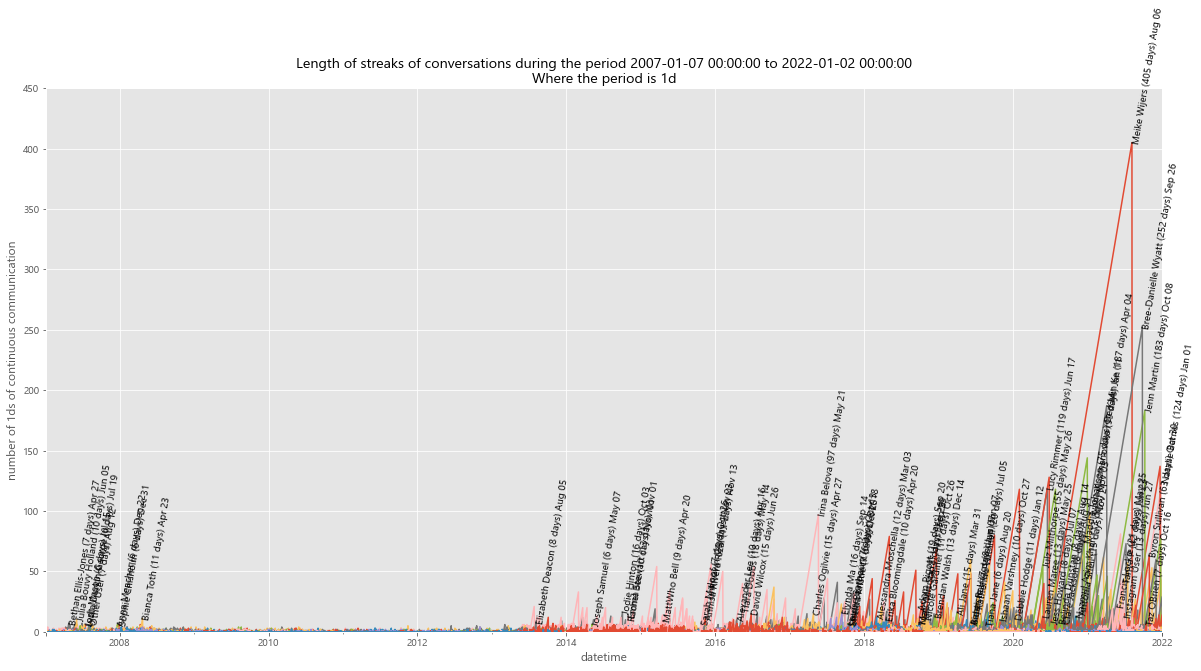

<Figure size 1440x720 with 0 Axes>

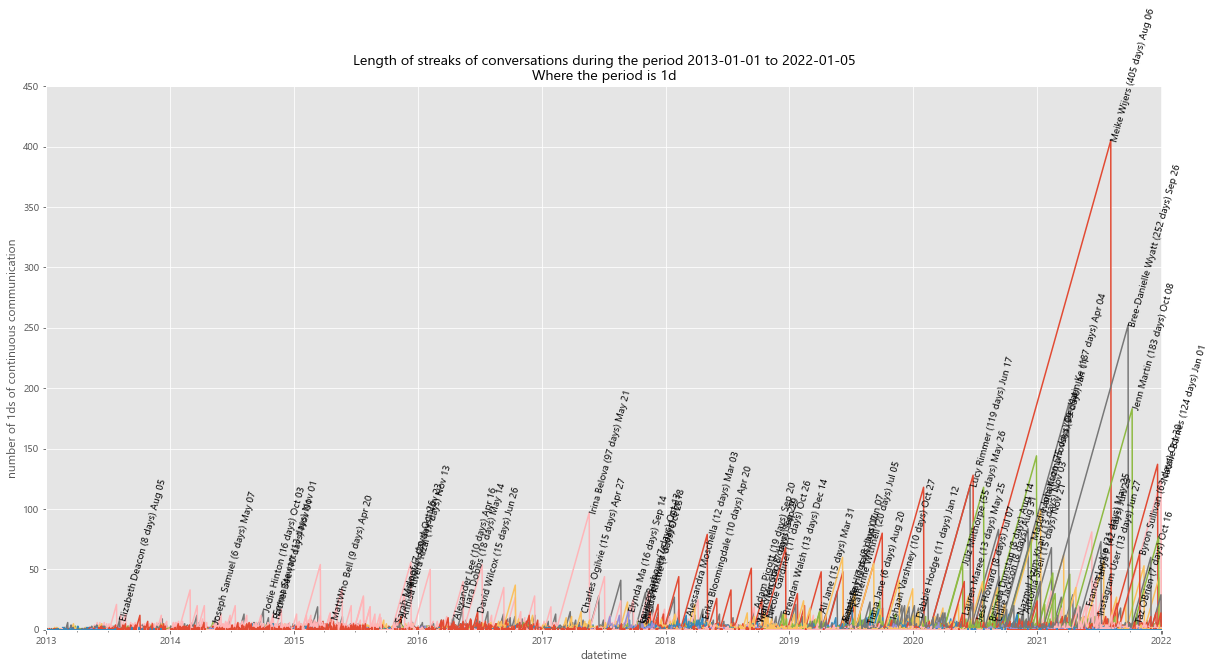

In [23]:
everyone_df = make_streak_df(all_convo_df, "1d")
plot_streak_graph(everyone_df, period="1d", time_span=False, period_name="days", ylim=[0, 450])
plot_streak_graph(everyone_df, period="1d", period_name="days", ylim=[0, 450])

<Figure size 1440x720 with 0 Axes>

c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 969 missing from current font.
  fo

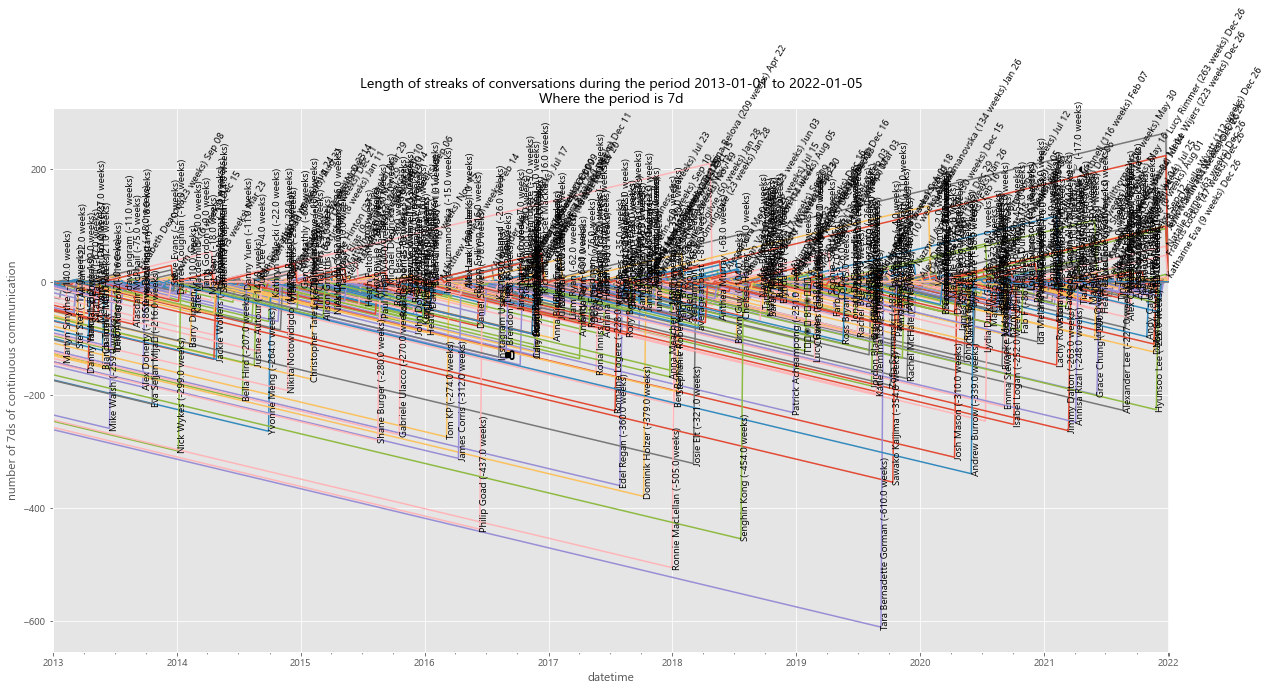

<Figure size 1440x720 with 0 Axes>

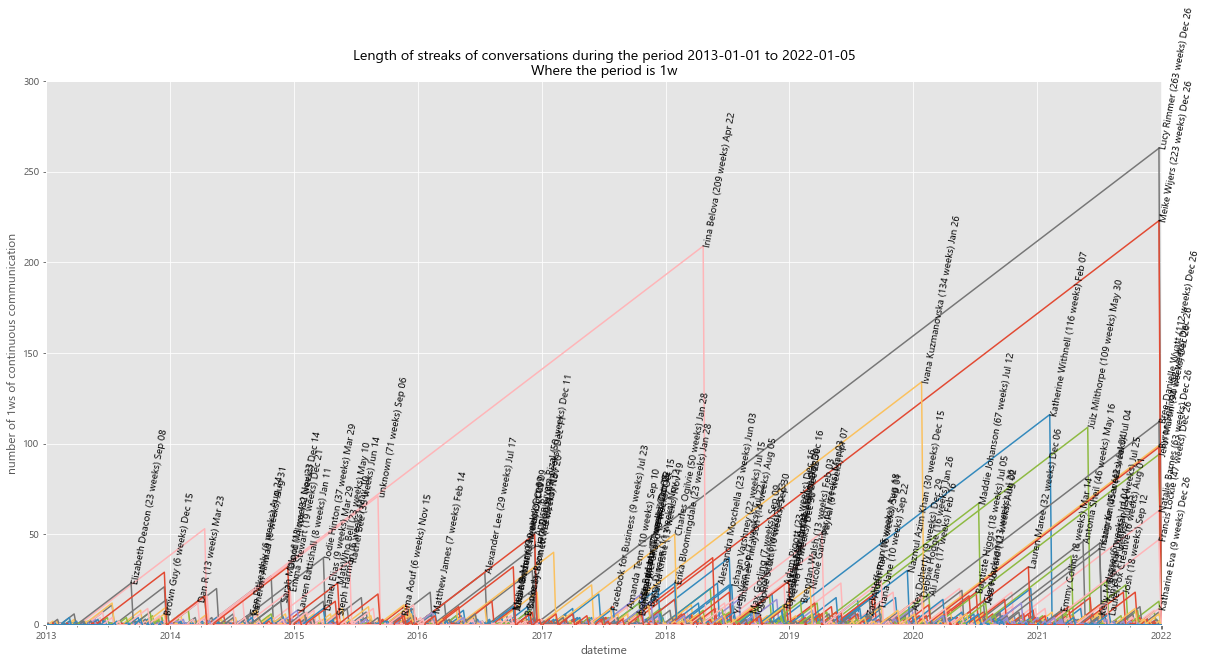

<Figure size 1440x720 with 0 Axes>

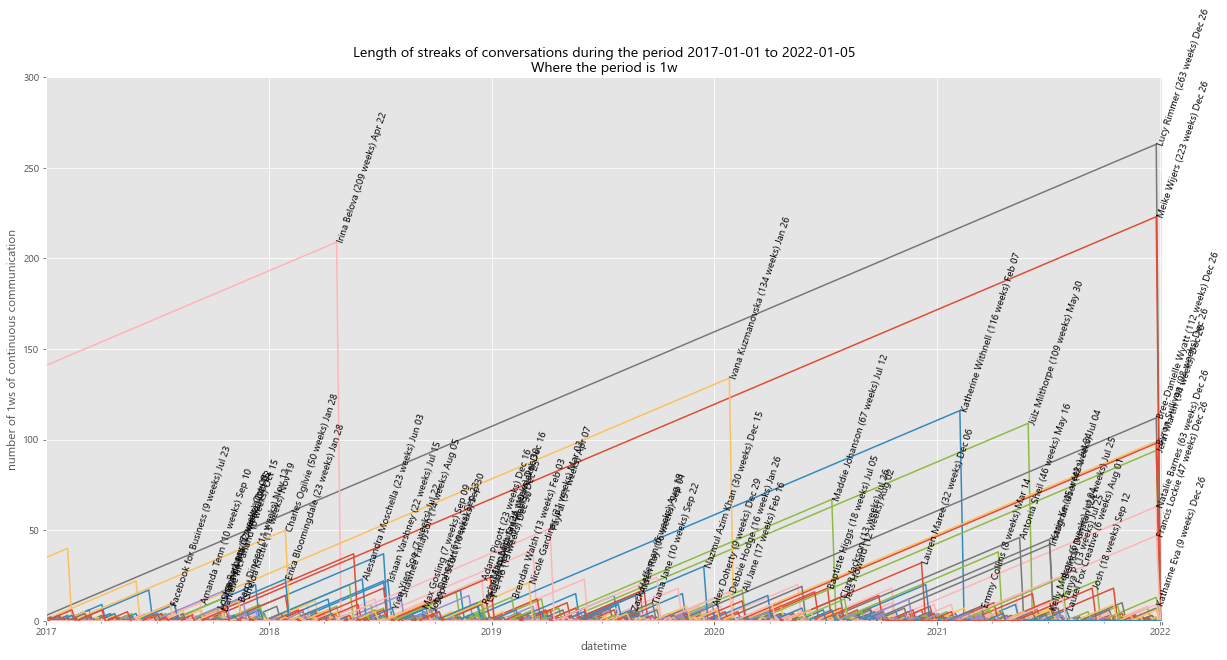

In [24]:
everyone_df = make_streak_df(all_convo_df, "7d")
plot_streak_graph(everyone_df, period="7d", period_name="weeks", ylim=False)
plot_streak_graph(everyone_df, period="1w", period_name="weeks", ylim=[0, 300])
plot_streak_graph(everyone_df, period="1w", period_name="weeks", ylim=[0, 300], time_span=["2017-01-01", "2022-01-05"])

<Figure size 1440x720 with 0 Axes>

c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\ben\Documents\UNSW\1161\data_project_2021\dp-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 969 missing from current font.
  fo

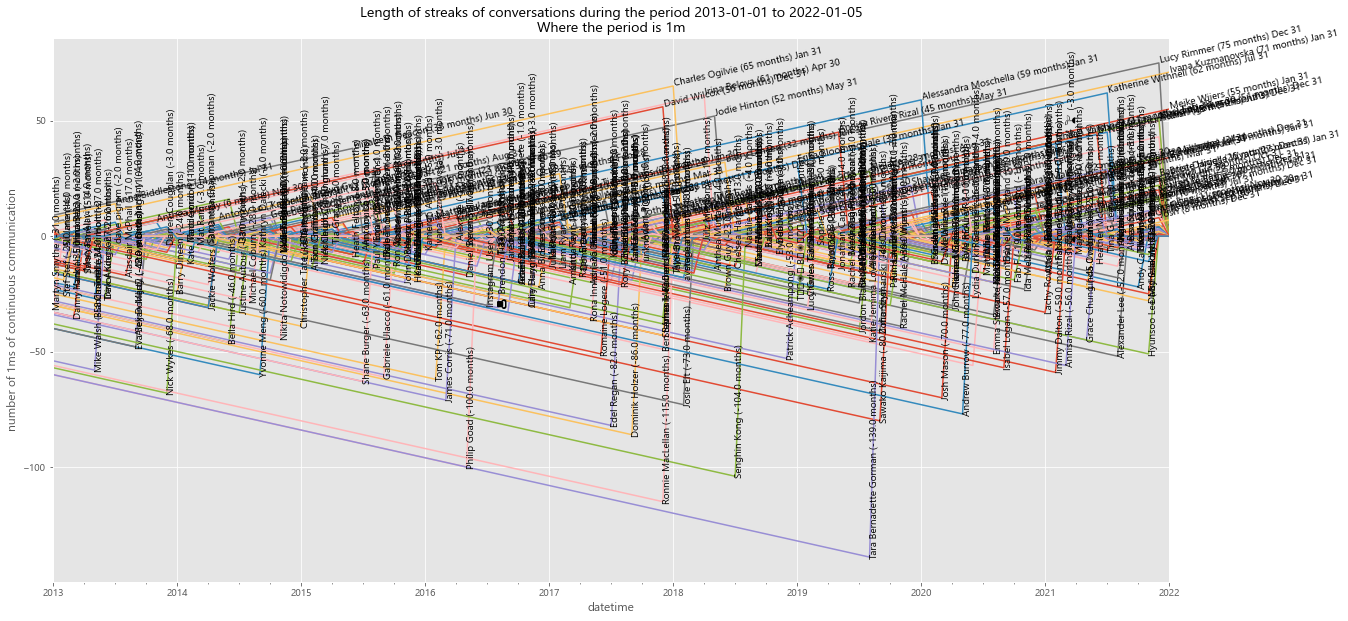

In [25]:
everyone_df = make_streak_df(all_convo_df, "1m")
plot_streak_graph(everyone_df, period="1m", period_name="months", ylim=False)